In [1]:
from random import Random
import numpy as np
import time
import math
import scipy as sp

import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Initial Set-up

In [81]:
## Function to calculate forward error of linear system solver
def cal_linsystem_forward_error(sol, x, p=2):
    return np.linalg.norm(sol-x,p)/np.linalg.norm(x,p)


## Function to compute linear system solution using Cholesky
def cholesky_solver(K,x, y, p=2):
    #Matrix Decomposition
    tic = time.time()
    L = sp.linalg.cholesky(K, lower = True)
    toc = time.time()
    decomp_time = toc-tic
    #Linear solver
    tic1 = time.time()
    lower = True
    sol = sp.linalg.cho_solve((L, lower), y) 
    toc1 = time.time()
    lin_solve_time = toc1-tic1
    #Compute error
    decomp_error = np.linalg.norm(L@L.T-K,p)/np.linalg.norm(K,p)
    lin_forward_error = np.linalg.norm(sol-x,p)/np.linalg.norm(x,p)
    
    return decomp_time, lin_solve_time, decomp_error, lin_forward_error

## Function to compute linear system solution using SVD
def svd_solver(K,x,y, p=2):
    #Matrix Decomposition
    tic = time.time()
    U,S,Vh = np.linalg.svd(K,full_matrices=False)
    toc = time.time()
    decomp_time = toc-tic
    decomp_error = np.linalg.norm(U@np.diag(S)@Vh-K,p)/np.linalg.norm(K,p)
    
    #Linear solver
    tic1 = time.time()
    c = U.T@y
    w = np.linalg.solve(np.diag(S),c)
    sol = Vh.T@w
    toc1 = time.time()
    lin_solve_time = toc1-tic1
    lin_forward_error = np.linalg.norm(sol-x,p)/np.linalg.norm(x,p)
    
    return decomp_time, lin_solve_time, decomp_error, lin_forward_error

## Function to compute linear system solution using QR
def qr_solver(K, x, y,p=2):
    #Matrix Decomposition
    tic = time.time()
    Q, R = np.linalg.qr(K)
    toc = time.time()
    decomp_time = toc-tic
    decomp_error = np.linalg.norm(Q@R - K, p)/np.linalg.norm(K,p)
    
    #Linear solver
    tic1 = time.time()
    p = Q.T@y
    sol = np.linalg.inv(R)@p
    toc1 = time.time()
    lin_solve_time = toc1-tic1
    
    return decomp_time, lin_solve_time, decomp_error, sol



## Function to experiment kernel matrix decomposition and linear system solver
def kernel_linear_testing(training_number, decomp_type, p = 2):
    #Generate K_y matrix
    x_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
    rbf= gaussian_process.kernels.RBF()
    Kernel= rbf(x_train, x_train)
    K_y = Kernel + np.eye(training_number) * 1e-8

    #Generate x vector (vector of 1)
    x = np.ones((training_number,1), dtype = 'int')

    #Generate y vector 
    y = K_y@x

    #Set up experiment for matrix decomposition and linear system solver
    if decomp_type == 'cho':
        decomp_time, lin_solve_time, decomp_error, lin_forward_error = cholesky_solver(K_y,x, y, p)
    elif decomp_type == 'svd':
        decomp_time, lin_solve_time, decomp_error, lin_forward_error = svd_solver(K_y,x, y, p)
    elif decomp_type == 'qr':
        decomp_time, lin_solve_time, decomp_error, sol_x = qr_solver(K_y,x, y, p)
        lin_forward_error = cal_linsystem_forward_error(sol_x, x, p)
    else:
        print ('Please select a decomposition method (svd, qr, cho)!')
        return 0
    
    #print ('Decompose K matrix at size', K_y.shape)
    #print("Total elapsed time for decomposing K matrix:", decomp_time, "seconds.")
    #print("Total elapsed time for solving Kx = y:", lin_solve_time, "seconds.")
    #print ('Error from decomposition:', decomp_error)
    #print ('Forward Error from linear system solver:', lin_forward_error)
    
    return decomp_time, lin_solve_time, decomp_error, lin_forward_error
    
    

In [82]:
a, b, c, d = kernel_linear_testing(30, decomp_type = 'qr', p = 2)
d

3.545316440719059e-07

# Testing

In [11]:
## Test different size of matrices
## Cholesky method
n_size = []
decomp_time =[]
lin_solve_time = []
decomp_error = []
#lin_backerror = []
lin_forerror = []
for i in range(100, 1800, 20):
    n_size.append(i)
    decomp_t, lin_t, decomp_err, lin_forerr = kernel_linear_testing(i, 'cho',p=2)
    decomp_time.append(decomp_t)
    lin_solve_time.append(lin_t)
    decomp_error.append(decomp_err)
    lin_forerror.append(lin_forerr)
    #lin_backerror.append(lin_backerr)
    

In [12]:
## Test different size of matrices
## SVD method
n_size_2 = []
decomp_time_2 =[]
lin_solve_time_2 = []
decomp_error_2 = []
#lin_backerror = []
lin_forerror_2 = []
for i in range(100, 1800, 20):
    n_size_2.append(i)
    decomp_t, lin_t, decomp_err, lin_forerr = kernel_linear_testing(i, 'svd',p=2)
    decomp_time_2.append(decomp_t)
    lin_solve_time_2.append(lin_t)
    decomp_error_2.append(decomp_err)
    lin_forerror_2.append(lin_forerr)

In [84]:
## Test different size of matrices
## QR method
n_size_3 = []
decomp_time_3 =[]
lin_solve_time_3 = []
decomp_error_3 = []
lin_forerror_3 = []
for i in range(100, 1800, 20):
    n_size_3.append(i)
    decomp_t, lin_t, decomp_err, lin_forerr = kernel_linear_testing(i, 'qr',p=2)
    decomp_time_3.append(decomp_t)
    lin_solve_time_3.append(lin_t)
    decomp_error_3.append(decomp_err)
    lin_forerror_3.append(lin_forerr)

In [13]:
#Obtain machine epsilon
print(np.finfo(float).eps)

2.220446049250313e-16


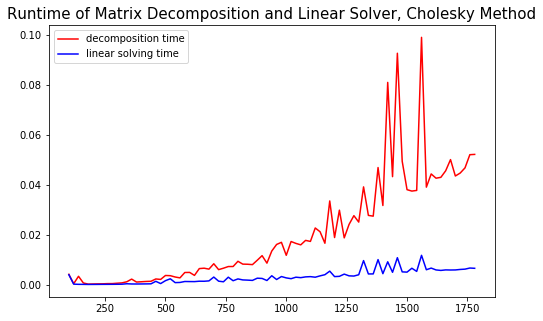

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(n_size,decomp_time, '-', c = 'r', label = 'decomposition time' )
plt.plot(n_size, lin_solve_time, '-', c = 'b', label = 'linear solving time')
plt.title('Runtime of Matrix Decomposition and Linear Solver, Cholesky Method', fontsize = 15)
plt.legend()


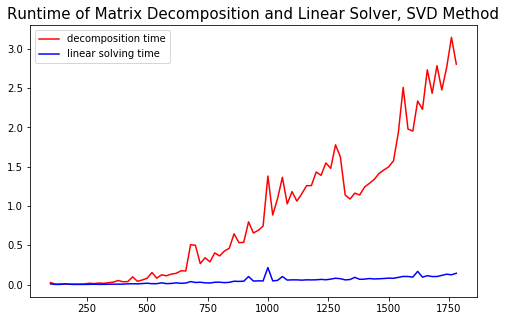

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(n_size,decomp_time_2, '-', c = 'r', label = 'decomposition time' )
plt.plot(n_size, lin_solve_time_2, '-', c = 'b', label = 'linear solving time')
plt.title('Runtime of Matrix Decomposition and Linear Solver, SVD Method', fontsize = 15)
plt.legend()

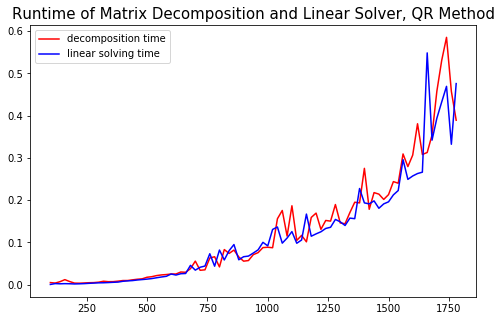

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(n_size_3,decomp_time_3, '-', c = 'r', label = 'decomposition time' )
plt.plot(n_size_3, lin_solve_time_3, '-', c = 'b', label = 'linear solving time')
plt.title('Runtime of Matrix Decomposition and Linear Solver, QR Method', fontsize = 15)
plt.legend()

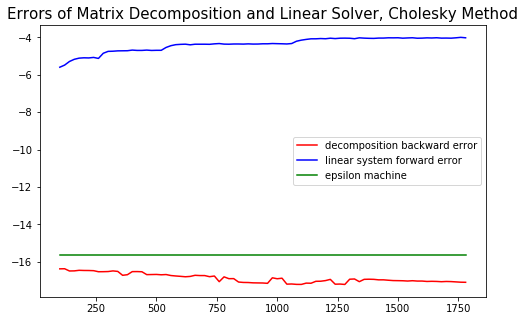

In [17]:
plt.figure(figsize=(8, 5))
decomp_error_log = [np.log10(i) for i in decomp_error]
lin_forerror_log = [np.log10(i) for i in lin_forerror]
eps_machine = [np.log10(np.finfo(float).eps) for i in range(len(decomp_error))]

plt.plot(n_size, decomp_error_log, '-', c = 'r', label = 'decomposition backward error' )
plt.plot(n_size, lin_forerror_log, '-', c = 'b', label = 'linear system forward error')
plt.plot(n_size, eps_machine, '-', c = 'g', label = 'epsilon machine')
plt.title('Errors of Matrix Decomposition and Linear Solver, Cholesky Method', fontsize = 15)
plt.legend()


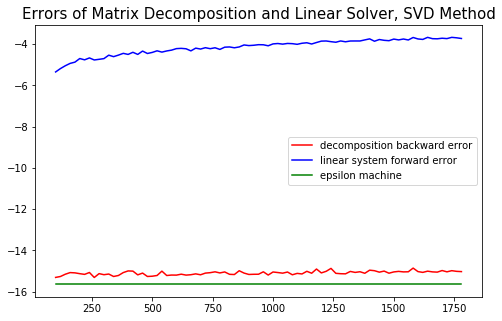

In [18]:
plt.figure(figsize=(8, 5))
decomp_error_log_2 = [np.log10(i) for i in decomp_error_2]
lin_forerror_log_2 = [np.log10(i) for i in lin_forerror_2]
eps_machine = [np.log10(np.finfo(float).eps) for i in range(len(decomp_error_2))]

plt.plot(n_size_2, decomp_error_log_2, '-', c = 'r', label = 'decomposition backward error' )
plt.plot(n_size_2, lin_forerror_log_2, '-', c = 'b', label = 'linear system forward error')
plt.plot(n_size_2, eps_machine, '-', c = 'g', label = 'epsilon machine')
plt.title('Errors of Matrix Decomposition and Linear Solver, SVD Method', fontsize = 15)
plt.legend()

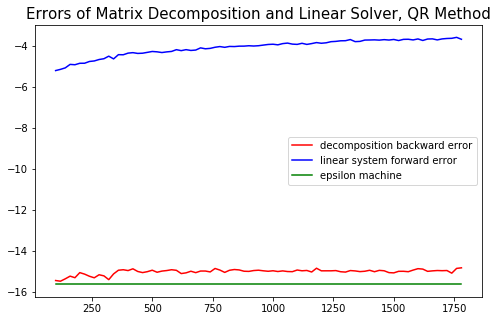

In [86]:
plt.figure(figsize=(8, 5))
decomp_error_log_3 = [np.log10(i) for i in decomp_error_3]
lin_forerror_log_3 = [np.log10(i) for i in lin_forerror_3]
eps_machine = [np.log10(np.finfo(float).eps) for i in range(len(decomp_error_3))]

plt.plot(n_size_3, decomp_error_log_3, '-', c = 'r', label = 'decomposition backward error' )
plt.plot(n_size_3, lin_forerror_log_3, '-', c = 'b', label = 'linear system forward error')
plt.plot(n_size_3, eps_machine, '-', c = 'g', label = 'epsilon machine')
plt.title('Errors of Matrix Decomposition and Linear Solver, QR Method', fontsize = 15)
plt.legend()
